In [56]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

np.set_printoptions(linewidth=np.inf, suppress=True, precision=2)

In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score 

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import tensorflow as tf

from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,ExpSineSquared, DotProduct,ConstantKernel)
from sklearn.gaussian_process import GaussianProcessRegressor  
from sklearn.svm import SVR

import mitosheet

In [3]:
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

pyo.init_notebook_mode(connected=True)

### Unstructured Variance, n_input = 12, n_output = 1

In [4]:
df = pd.read_excel("Data/US12I1O.xlsx", index_col = 0)
df

,Input 1,Input 2,Input 3,Input 4,Input 5,Input 6,Input 7,Input 8,Input 9,Input 10,Input 11,Input 12,Output 1
DMU 1,288.81,493.46,202.31,356.18,384.45,653.77,129.40,100.28,38.45,306.59,92.41,250.91,250.77
DMU 2,349.98,420.00,139.32,312.89,543.04,504.54,120.43,177.65,86.96,330.87,79.16,201.81,372.71
DMU 3,280.78,452.42,127.85,315.42,559.22,466.35,166.57,165.57,81.43,359.75,83.23,246.78,293.40
DMU 4,405.33,376.32,237.28,451.43,414.19,318.03,187.77,154.65,49.71,316.82,97.74,344.70,462.69
DMU 5,348.96,426.79,170.01,292.91,502.76,342.94,146.53,165.78,63.80,329.79,76.17,355.61,374.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
DMU 996,206.54,333.40,274.01,424.09,465.99,548.04,143.02,58.25,49.65,355.16,85.54,238.49,279.23
DMU 997,328.82,415.09,121.60,268.46,494.32,454.22,150.96,143.44,65.04,374.88,69.81,261.57,344.45
DMU 998,310.52,565.44,126.06,320.91,463.01,390.07,151.81,202.55,101.67,333.12,87.52,328.13,320.62
DMU 999,390.34,255.88,209.15,269.76,576.57,261.14,162.39,102.92,66.70,401.16,72.50,318.26,380.24


In [5]:
df_sol = pd.read_excel("Data/US12I1O_Solution.xlsx", index_col = 0, header=1)
df_sol

,Efficiency
DMU,
DMU 1,0.501907
DMU 2,0.791705
DMU 3,0.565044
DMU 4,0.860990
DMU 5,0.701855
...,...
DMU 996,0.670301
DMU 997,0.741442
DMU 998,0.622777


In [6]:
import mitosheet
mitosheet.sheet(df_sol, view_df=True)

MitoWidget(analysis_data_json='{"analysisName": "UUID-0c256ba4-c667-4b19-98b1-890698112de7", "code": {"imports…

In [7]:
df_weights = pd.read_excel("Data/US12I1O_Solution.xlsx", index_col = 0, header=1, sheet_name="InputOutputWeights")
df_weights

,Efficiency,Input 9,Input 10,Input 1,Input 6,Input 12,Input 4,Input 2,Input 3,Input 7,Input 8,Input 11,Input 5,Output 1
DMU,,,,,,,,,,,,,,
DMU 1,0.501907,0.007462,0.0,0.000000,0.000000,0.000411,0.0,0.0,0.001253,0.000000,0.002144,0.000000,0.000368,0.002001
DMU 2,0.791705,0.000000,0.0,0.000000,0.000000,0.001477,0.0,0.0,0.002071,0.003432,0.000000,0.000000,0.000000,0.002124
DMU 3,0.565044,0.000000,0.0,0.000250,0.000309,0.002061,0.0,0.0,0.002169,0.000000,0.000000,0.000000,0.000000,0.001926
DMU 4,0.860990,0.008602,0.0,0.000000,0.000904,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000688,0.001861
DMU 5,0.701855,0.000000,0.0,0.000000,0.000096,0.000000,0.0,0.0,0.001487,0.000000,0.000000,0.009375,0.000000,0.001876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DMU 996,0.670301,0.001436,0.0,0.002101,0.000000,0.000000,0.0,0.0,0.000752,0.000000,0.004488,0.000000,0.000058,0.002401
DMU 997,0.741442,0.000088,0.0,0.000000,0.000000,0.000066,0.0,0.0,0.001710,0.000000,0.000324,0.010350,0.000000,0.002153
DMU 998,0.622777,0.000000,0.0,0.000088,0.000754,0.000000,0.0,0.0,0.002191,0.000000,0.000000,0.000000,0.000869,0.001942


In [8]:
(df_weights==0).sum()

Efficiency      0
Input 9       588
Input 10      829
Input 1       302
Input 6       359
Input 12      715
Input 4       709
Input 2       805
Input 3       199
Input 7       653
Input 8       380
Input 11      741
Input 5       672
Output 1        0
dtype: int64

### ML

In [9]:
X = df
X.head()

,Input 1,Input 2,Input 3,Input 4,Input 5,Input 6,Input 7,Input 8,Input 9,Input 10,Input 11,Input 12,Output 1
DMU 1,288.81,493.46,202.31,356.18,384.45,653.77,129.40,100.28,38.45,306.59,92.41,250.91,250.77
DMU 2,349.98,420.00,139.32,312.89,543.04,504.54,120.43,177.65,86.96,330.87,79.16,201.81,372.71
DMU 3,280.78,452.42,127.85,315.42,559.22,466.35,166.57,165.57,81.43,359.75,83.23,246.78,293.40
DMU 4,405.33,376.32,237.28,451.43,414.19,318.03,187.77,154.65,49.71,316.82,97.74,344.70,462.69
DMU 5,348.96,426.79,170.01,292.91,502.76,342.94,146.53,165.78,63.80,329.79,76.17,355.61,374.18


In [10]:
y = df_sol
y.head()

,Efficiency
DMU,
DMU 1,0.501907
DMU 2,0.791705
DMU 3,0.565044
DMU 4,0.860990
DMU 5,0.701855


In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
std_scaler = StandardScaler()
mm_scaler = MinMaxScaler()

In [12]:
dt_model = DecisionTreeRegressor(random_state=42)

pipe_dt = make_pipeline(std_scaler, dt_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_dt, X, y, scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_dt, X, y, scoring="r2").mean())

neg_mean_squared_error: -0.005202921745509041
neg_root_mean_squared_error: -0.07207765575976034
r2: 0.6745284961591365


In [13]:
# specify parameter values to search
params = {}
params['decisiontreeregressor__max_depth'] = list(range(1, 15))
params['decisiontreeregressor__min_samples_split'] = list(range(10, 60, 10))
params['decisiontreeregressor__max_features'] = ["auto","log2","sqrt",None]

In [14]:
grid = GridSearchCV(pipe_dt, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=42))]),
             param_grid={'decisiontreeregressor__max_depth': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14],
                         'decisiontreeregressor__max_features': ['auto', 'log2',
                                                                 'sqrt', None],
                         'decisiontreeregressor__min_samples_split': [10, 20,
                                                                      30, 40,
                                                                      50]},
             scoring='neg_root_mean_squared_error')

In [15]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y, scoring="r2").mean())

-0.06419162394897762
{'decisiontreeregressor__max_depth': 13, 'decisiontreeregressor__max_features': 'auto', 'decisiontreeregressor__min_samples_split': 40}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=13, max_features='auto',
                                       min_samples_split=40,
                                       random_state=42))])
r2: 0.739666171718348


In [16]:
imp_dt = grid.best_estimator_.steps[1][1].feature_importances_
imp_dt

array([0.03, 0.  , 0.03, 0.01, 0.  , 0.02, 0.02, 0.04, 0.03, 0.  , 0.01, 0.  , 0.81])

In [17]:
#pipe_dt.fit(X, y)
#
#imp_dt = pipe_dt.steps[1][1].feature_importances_
#imp_dt

In [18]:
df_dt = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_dt}).sort_values("Importance", ascending=False)
df_dt

,Feature Name,Importance
12,Output 1,0.807431
7,Input 8,0.036786
0,Input 1,0.030032
8,Input 9,0.028091
2,Input 3,0.025816
...,...,...
10,Input 11,0.010232
1,Input 2,0.003346
4,Input 5,0.003320
9,Input 10,0.002958


In [19]:
fig = px.bar(df_dt, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"DecisionTreeRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [20]:
rf_model = RandomForestRegressor(random_state=42)

pipe_rf = make_pipeline(std_scaler, rf_model)


# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_rf, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0024211453781061445
neg_root_mean_squared_error: -0.04903463240455258
r2: 0.847236494462153


In [21]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
print(n_estimators)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
print(max_depth)
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


In [22]:
# specify parameter values to search
params = {}
params['randomforestregressor__n_estimators'] = n_estimators
params['randomforestregressor__max_features'] = max_features
params['randomforestregressor__max_depth'] = max_depth
params['randomforestregressor__min_samples_split'] = min_samples_split
params['randomforestregressor__min_samples_leaf'] = min_samples_leaf
params['randomforestregressor__bootstrap'] = bootstrap

In [23]:
grid = RandomizedSearchCV(pipe_rf, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'randomforestregressor__bootstrap': [True,
                                                                             False],
                                        'randomforestregressor__max_depth': [10,
                                                                             20,
                                                                             30,
                                                                             40,
                                                                             50,
                                                                             60,
                                

In [24]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.04943108234170033
{'randomforestregressor__n_estimators': 400, 'randomforestregressor__min_samples_split': 10, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 50, 'randomforestregressor__bootstrap': True}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=50, min_samples_split=10,
                                       n_estimators=400, random_state=42))])
r2: 0.8448172057088226


In [25]:
imp_rf = grid.best_estimator_.steps[1][1].feature_importances_
imp_rf

array([0.03, 0.01, 0.03, 0.02, 0.01, 0.02, 0.02, 0.04, 0.03, 0.01, 0.02, 0.01, 0.76])

In [26]:
#pipe_rf.fit(X, y.values.ravel())
#
#imp_rf = pipe_rf.steps[1][1].feature_importances_

In [27]:
df_rf = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_rf}).sort_values("Importance", ascending=False)
df_rf

,Feature Name,Importance
12,Output 1,0.757851
7,Input 8,0.040425
8,Input 9,0.034066
0,Input 1,0.031937
2,Input 3,0.029508
...,...,...
3,Input 4,0.017027
9,Input 10,0.007418
1,Input 2,0.007063
11,Input 12,0.006401


In [28]:
fig = px.bar(df_rf, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"RandomForestRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [29]:
gb_model = GradientBoostingRegressor(random_state=42)

pipe_gb = make_pipeline(std_scaler, gb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_gb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0017086686098910207
neg_root_mean_squared_error: -0.041234775039966844
r2: 0.893201579245642


In [30]:
#learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
#n_estimators = [200, 500, 1000, 2000]
#max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
#print(max_depth)
#max_depth.append(None)
## Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
## Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]

In [52]:
learning_rate = [1, 0.5, 0.1,  0.01]
n_estimators = [50, 100, 200, 500, 1000, 2000]
max_depth = [3, 5, 10, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
subsample = [0.3, 0.5, 0.75, 1.0]

In [53]:
# specify parameter values to search
params = {}
params['gradientboostingregressor__learning_rate'] = learning_rate
params['gradientboostingregressor__n_estimators'] = n_estimators
params['gradientboostingregressor__max_depth'] = max_depth
params['gradientboostingregressor__min_samples_split'] = min_samples_split
params['gradientboostingregressor__min_samples_leaf'] = min_samples_leaf
params['gradientboostingregressor__subsample'] = subsample

In [54]:
grid = RandomizedSearchCV(pipe_gb, params, cv=5, scoring="neg_root_mean_squared_error", random_state=0)
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('gradientboostingregressor',
                                              GradientBoostingRegressor(random_state=42))]),
                   param_distributions={'gradientboostingregressor__learning_rate': [1,
                                                                                     0.5,
                                                                                     0.1,
                                                                                     0.01],
                                        'gradientboostingregressor__max_depth': [3,
                                                                                 5,
                                                                                 10,
                                                                 

In [57]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.03160467698857672
{'gradientboostingregressor__subsample': 0.3, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__min_samples_split': 30, 'gradientboostingregressor__min_samples_leaf': 2, 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__learning_rate': 0.1}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, min_samples_leaf=2,
                                           min_samples_split=30,
                                           n_estimators=500, random_state=42,
                                           subsample=0.3))])
r2: 0.9365859627287326


In [35]:
imp_gb = grid.best_estimator_.steps[1][1].feature_importances_
imp_gb

array([0.04, 0.01, 0.04, 0.02, 0.01, 0.03, 0.03, 0.05, 0.04, 0.01, 0.01, 0.  , 0.71])

In [36]:
#pip_gb.fit(X, y.values.ravel())
#
#imp_gb = pip_gb.steps[1][1].feature_importances_

In [37]:
df_gb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_gb}).sort_values("Importance", ascending=False)
df_gb

,Feature Name,Importance
12,Output 1,0.708500
7,Input 8,0.049076
8,Input 9,0.039683
0,Input 1,0.039250
2,Input 3,0.035188
...,...,...
10,Input 11,0.012982
1,Input 2,0.012739
9,Input 10,0.009548
4,Input 5,0.007014


In [38]:
fig = px.bar(df_gb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"GradientBoostingRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [59]:
model = grid.best_estimator_.fit(X_train, y_train.values.ravel())
prediction = model.predict(X_test)

In [60]:
res = pd.DataFrame()
res["Prediction"] = pd.Series(prediction.ravel())
res["Actual"] = y_test.values
res["Diff"] = res.Prediction - res.Actual
res["Error_Perc"] = ((res.Prediction - res.Actual) / res.Actual) * 100 
res["Error_Perc < 3"] = np.abs(res["Error_Perc"]) < 3  
res = res.round(4)
res.index = X_test.index
res

,Prediction,Actual,Diff,Error_Perc,Error_Perc < 3
DMU 522,0.7567,0.7514,0.0053,0.7067,True
DMU 738,0.8446,0.8656,-0.0210,-2.4269,True
DMU 741,0.9731,1.0000,-0.0269,-2.6929,True
DMU 661,0.9062,0.8711,0.0352,4.0380,False
DMU 412,0.7594,0.7903,-0.0310,-3.9179,False
...,...,...,...,...,...
DMU 409,0.7627,0.7837,-0.0209,-2.6678,True
DMU 333,0.8888,0.8507,0.0380,4.4709,False
DMU 209,0.8714,0.8364,0.0349,4.1760,False
DMU 614,0.9542,1.0000,-0.0458,-4.5769,False


In [61]:
blue = res["Error_Perc < 3"].sum()
print(blue)
red = len(res["Error_Perc < 3"]) - (res["Error_Perc < 3"].sum())
red

121


79

In [62]:
rho, p = stats.spearmanr(res.Prediction, res.Actual)
print("rho:", rho.round(4)) 
print("p-Value", p.round(4)) 

rho: 0.9554
p-Value 0.0


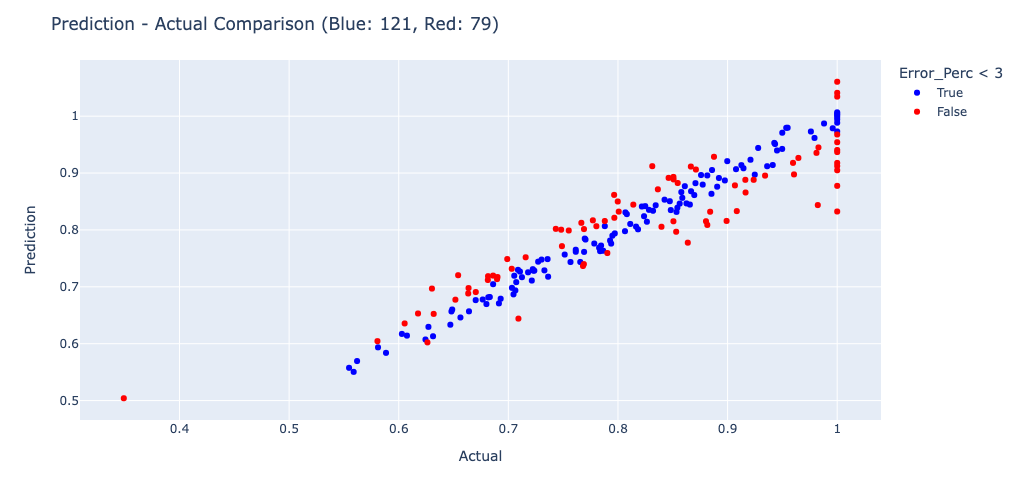

In [63]:
fig = px.scatter(res.reset_index().rename(columns={'index': 'DMU'}), x="Actual", y="Prediction", color = "Error_Perc < 3", color_discrete_map= {True:"blue", False: "red"},
                 hover_data=["Actual", "Prediction", "Error_Perc", "DMU"])

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"Prediction - Actual Comparison (Blue: {blue}, Red: {red})",
)

fig.show()

In [39]:
xgb_model = xgb.XGBRegressor(random_state=42)

pipe_xgb = make_pipeline(std_scaler, xgb_model)

# cross-validate the pipeline
print("neg_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_mean_squared_error").mean())
print("neg_root_mean_squared_error:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="neg_root_mean_squared_error").mean())
print("r2:", cross_val_score(pipe_xgb, X, y.values.ravel(), scoring="r2").mean())

neg_mean_squared_error: -0.0018494347607237588
neg_root_mean_squared_error: -0.042928641414298384
r2: 0.8835667848319246


In [40]:
# xgb.plot_tree(xgb_model,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 10]
# plt.show()

In [41]:
learning_rate = [0.01, 0.1, 0.2, 0.3]
n_estimators = [100, 500, 1000]
max_depth =  [3, 5, 6, 10, 15, 20]
subsample = np.arange(0.5, 1.0, 0.1)
colsample_bytree = np.arange(0.4, 1.0, 0.1)
colsample_bylevel = np.arange(0.4, 1.0, 0.1)

In [42]:
# specify parameter values to search
params = {}
params['xgbregressor__learning_rate'] = learning_rate
params['xgbregressor__n_estimators'] = n_estimators
params['xgbregressor__max_depth'] = max_depth
params['xgbregressor__subsample'] = subsample
params['xgbregressor__colsample_bytree'] = colsample_bytree
params['xgbregressor__colsample_bylevel'] = colsample_bylevel

In [43]:
grid = RandomizedSearchCV(pipe_xgb, params, cv=5, scoring="neg_root_mean_squared_error")
grid.fit(X, y.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           enable_categorical=False,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type=None,
                                                           interaction_constrai

In [44]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print("r2:", cross_val_score(grid.best_estimator_, X, y.values.ravel(), scoring="r2").mean())

-0.034654275366153425
{'xgbregressor__subsample': 0.8999999999999999, 'xgbregressor__n_estimators': 1000, 'xgbregressor__max_depth': 3, 'xgbregressor__learning_rate': 0.1, 'xgbregressor__colsample_bytree': 0.6, 'xgbregressor__colsample_bylevel': 0.6}
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=0.6, colsample_bynode=1,
                              colsample_bytree=0.6, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=42, re

In [45]:
imp_xgb = grid.best_estimator_.steps[1][1].feature_importances_
imp_xgb

array([0.05, 0.02, 0.03, 0.03, 0.03, 0.03, 0.04, 0.05, 0.05, 0.05, 0.03, 0.01, 0.59], dtype=float32)

In [46]:
df_xgb = pd.DataFrame({"Feature Name":X.columns, "Importance": imp_xgb}).sort_values("Importance", ascending=False)
df_xgb

,Feature Name,Importance
12,Output 1,0.593746
0,Input 1,0.051335
9,Input 10,0.045817
7,Input 8,0.045217
8,Input 9,0.045210
...,...,...
4,Input 5,0.027483
10,Input 11,0.026498
3,Input 4,0.026427
1,Input 2,0.019991


In [47]:
fig = px.bar(df_xgb, x="Importance", y="Feature Name")

fig.update_layout(
    autosize=False,
    width=800,
    height=500,
    title_text=f"XGBRegressor Feature Importances",
    yaxis={'categoryorder':'total ascending'}
)

fig.show()

In [48]:
pipe_xgb.fit(X, y.values.ravel())

pipe_xgb.steps[1][1].feature_importances_

array([0.03, 0.01, 0.03, 0.02, 0.01, 0.03, 0.02, 0.06, 0.04, 0.01, 0.02, 0.01, 0.72], dtype=float32)

In [49]:
pipe_xgb.steps[1][1].get_booster().get_score(importance_type='cover')

{'f0': 117.03125,
 'f1': 141.41488647460938,
 'f2': 151.65528869628906,
 'f3': 166.66030883789062,
 'f4': 139.1904754638672,
 'f5': 203.20799255371094,
 'f6': 188.8685302734375,
 'f7': 231.1220703125,
 'f8': 175.75242614746094,
 'f9': 182.1999969482422,
 'f10': 180.78282165527344,
 'f11': 194.33871459960938,
 'f12': 275.85504150390625}

In [50]:
plt.rcParams['figure.figsize'] = [12, 10]

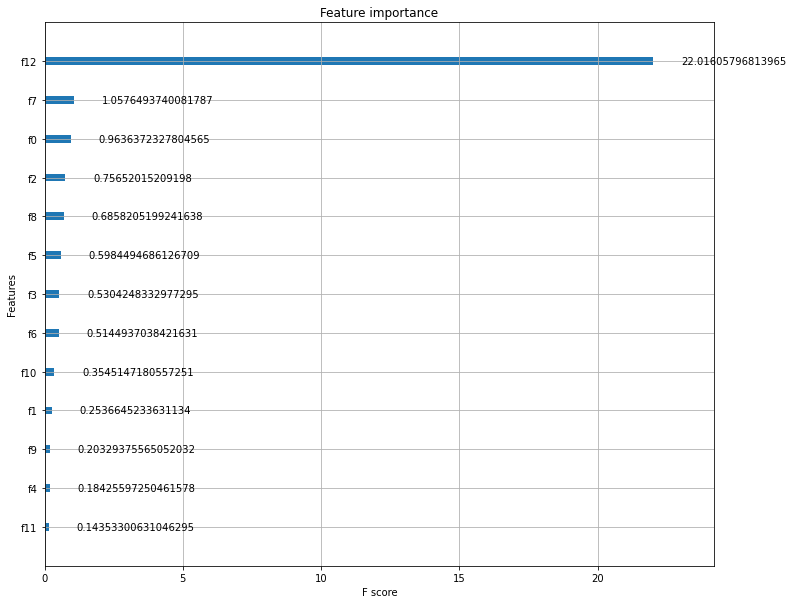

In [51]:
xgb.plot_importance(pipe_xgb.steps[1][1]._Booster, importance_type='total_gain')
plt.show()